In [1]:
from graph_tool.all import *
import pandas as pd
import numpy as np
import csv
import time
import json
import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
big_data = '/home/ryan/git-repos/bitcoin_networks/ether_data/final_etherum_data/time_sorted_ethereum_edge_list.csv'

# Small datafiles to be created.
june_1_data = '/home/ryan/git-repos/bitcoin_networks/ether_data/final_etherum_data/june_1_data/june_1_edge_list.csv'
july_1_data = '/home/ryan/git-repos/bitcoin_networks/ether_data/final_etherum_data/june_1_data/july_1_edge_list.csv'

start_time = 1498867200


In [ ]:
def get_date_edge_list(big_data, small_data, start_time, num_hours):
    end_time = start_time + (3600 * num_hours)
    edge_list = []
    with open(big_data, 'r') as f:
        reader = csv.reader(f, delimiter=' ')
        for row in reader:
            if float(row[-1]) > float(end_time):
                break
            if float(row[-1]) > float(start_time):
                edge_list.append(row)
    f.close()
    with open(small_data, 'w') as f:
        writer = csv.writer(f, delimiter=' ')
        writer.writerows(edge_list)
    f.close()


data_file = '/home/ryan/git-repos/bitcoin_networks/ether_data/final_etherum_data/june_1_data/july_1_edge_list.csv'
def get_data_buckets(datafile, start_time, num_hours):
    edge_list = []
    with open(datafile, 'r') as f:
        reader = csv.reader(f, delimiter=' ')
        for row in reader:
            edge_list.append(row)
    f.close()

    #iterate through the edge list, and create hourly sublists.
    bucket_list = []
    bucket = []

    while len(edge_list) > 1:
        end_time = start_time + (3600 * num_hours)
        edge = edge_list.pop() # Popping goes in reverse order.
        # Get the 1 hour boundary value.
        bucket_boundary = 3600 * (len(bucket_list) + 1)
        cur_time = edge[-1]
        bound = (end_time - bucket_boundary)
        if int(edge[-1]) < end_time - bucket_boundary:
            bucket_list.append(bucket)
            bucket = []
        else:
            bucket.append(edge)
    # Append the final bucket
    bucket_list.append(bucket)
    return bucket_list


def get_n_largest_components(G, num_components):
    v, hist = graph_tool.topology.label_components(G)
    n_component_labels = hist.argsort()[-num_components:]

    graph_list = []
    for value in n_component_labels:
        graph_list.append(graph_tool.GraphView(G, vfilt=(v.a == value)))
    return graph_list


def gather_metrics(bucket_list, num_hours, window_size, start_time):
    data_dump = {}
    for i in range(num_hours - window_size + 1):
        cur_list = []
        for j in range(window_size):
            cur_list += bucket_list[i + j]

        G = graph_tool.Graph()
        G.add_edge_list(cur_list, hashed=True, string_vals=True)
        tot_vertices = G.num_vertices()
        tot_in_degrees = G.get_in_degrees(G.get_vertices())
        tot_out_degrees = G.get_out_degrees(G.get_vertices())
#         print(tot_in_degrees == tot_out_degrees)
        tot_clustering_coefficient = graph_tool.clustering.global_clustering(G)  # Value, stddev
        # The total value traded within this window.
        tot_value = [float(val[2]) for val in cur_list]
        tot_value = sum(tot_value)

        subgraphs = get_n_largest_components(G, 3)
        subgraphs_data_list = []
        for graph in subgraphs:
            sub_vertices = graph.num_vertices()
            sub_in_degrees = graph.get_in_degrees(G.get_vertices())
            sub_out_degrees = graph.get_out_degrees(G.get_vertices())
#             print(sub_in_degrees == sub_out_degrees)
            sub_clustering_coefficient = graph_tool.clustering.global_clustering(graph)

            subgraph_data = {
                "num_vertices": sub_vertices,
                "in_degrees": sub_in_degrees.tolist(),
                "out_degrees": sub_out_degrees.tolist(),
                "clustering_coefficient": sub_clustering_coefficient
            }
            subgraphs_data_list.append(subgraph_data)

        iter_timestamp = start_time + 3600 * i
        iter_data = {
            "timestamp": iter_timestamp,
            "total_value": tot_value,
            "num_vertices": tot_vertices,
            "in_degrees": tot_in_degrees.tolist(),
            "out_degrees": tot_out_degrees.tolist(),
            "clustering_coefficient": tot_clustering_coefficient,
            "subgraph_1": subgraphs_data_list[0],
            "subgraph_2": subgraphs_data_list[1],
            "subgraph_3": subgraphs_data_list[2]
        }

        data_dump['iter_{}'.format(i)] = iter_data
    return data_dump


def main_collect_time_series(infile, outfile):
    start_time = 1498867200

    big_data = '/home/ryan/git-repos/bitcoin_networks/ether_data/final_etherum_data/time_sorted_ethereum_edge_list.csv'
    july_1_data = '/home/ryan/git-repos/bitcoin_networks/ether_data/final_etherum_data/june_1_data/july_1_edge_list.csv'

    # Get all transaction data within a given window
    bucket_list = get_data_buckets(infile, start_time=start_time, num_hours=24)

    # iterate through the data in hour increments.
    num_hours = 24
    window_size = 4

    data_dump = gather_metrics(bucket_list, num_hours, window_size, start_time)

    with open(outfile, 'w') as f:
        json.dump(data_dump, f)
        f.close()


def read_data(datafile):
    with open(datafile, 'r') as f:
        results = json.load(f)
    f.close()
    return results


def get_largest_component(iter_data):
    # As we experiment with different window sizes, it may prove useful to look at the different subgraphs.
    # However, for now, lets just look at the largest.
    largest_graph = iter_data['subgraph_1']
    subgraph_2 = iter_data['subgraph_2']
    subgraph_3 = iter_data['subgraph_3']
    if largest_graph['num_vertices'] < subgraph_2['num_vertices']:
        largest_graph = subgraph_2
    if largest_graph['num_vertices'] < subgraph_3['num_vertices']:
        largest_graph = subgraph_3
    return largest_graph


def get_deltas(xvals, yvals):
    new_list = []
    for i in range(1, len(yvals)):
        new_list.append(yvals[i] - yvals[i-1])
    return xvals[1:], new_list


def extract_data_from_json(data):
    ## Create an ordered list of data from every iteration
    timestamps = []
    total_value = []
    num_vertices = []
    num_subgraph_vertices = []
    in_degree_list = []
    subgraph_in_degree_list = []
    out_degree_list = []
    subgraph_out_degree_list = []
    clustering_coefficients = []
    subgraph_clustering_coefficients = []

    average_in_degrees = []
    subgraph_average_in_degrees = []
    average_out_degrees = []
    subgraph_average_out_degrees = []

    # Do some extraction stuff
    num_iters = len(data.keys())
    for i in range(num_iters):
        iter_data = data['iter_{}'.format(i)]
        subgraph_data = get_largest_component(iter_data)

        # Timestamp
        timestamps.append(iter_data['timestamp'])

        # Value traded
        total_value.append(iter_data['total_value'])

        # Number of Vertices
        num_vertices.append(iter_data['num_vertices'])
        num_subgraph_vertices.append(subgraph_data['num_vertices'])

        # In Degree Structure
        in_degree_list.append(iter_data['in_degrees'])
        subgraph_in_degree_list.append(subgraph_data['in_degrees'])

        # Out Degree Structure
        out_degree_list.append(iter_data['out_degrees'])
        subgraph_out_degree_list.append(subgraph_data['out_degrees'])

        # Clustering Coefficients
        clustering_coefficients.append(iter_data['clustering_coefficient'])
        subgraph_clustering_coefficients.append(subgraph_data['clustering_coefficient'])

        # Average In/Out Degrees
        average_in_degrees.append(np.mean(iter_data['in_degrees']))
        subgraph_average_in_degrees.append(np.mean(subgraph_data['in_degrees']))
        average_out_degrees.append(np.mean(iter_data['out_degrees']))
        subgraph_average_out_degrees.append(np.mean(subgraph_data['out_degrees']))

    # Store all extracted lists in a dictionary for convenient plotting.
    results = {
        'timestamps': timestamps,
        'total_value': total_value,
        'num_vertices': num_vertices,
        'num_subgraph_vertices': num_subgraph_vertices,
        'in_degree_list': in_degree_list,
        'subgraph_in_degree_list': subgraph_in_degree_list,
        'out_degree_list': out_degree_list,
        'subgraph_out_degree_list': subgraph_out_degree_list,
        'clustering_coefficients': clustering_coefficients,
        'subgraph_clustering_coefficients': subgraph_clustering_coefficients,
        'average_in_degrees': average_in_degrees,
        'subgraph_average_in_degrees': subgraph_average_in_degrees,
        'average_out_degrees': average_out_degrees,
        'subgraph_average_out_degrees': subgraph_average_out_degrees,
    }

    return results


def main_examine_time_series(datafile):
    loaded_file = read_data(datafile)
    results = extract_data_from_json(loaded_file)

    # Lets try plotting num_vertices vs time

    return results


def get_price_data_between_times(start_time, end_time):
    price_data = []
    with open('../ether_data/epoch_time.json', 'r') as f:
        total_price_data = json.load(f)
    f.close()

    total_price_data = total_price_data['data']
    for data in total_price_data:
        if int(data['time']) > end_time:
            break
        if int(data['time']) > start_time:
            price_data.append([int(data['time']), int(data['value'])])
    return price_data


In [ ]:
july_1_data = '/home/ryan/git-repos/bitcoin_networks/ether_data/final_etherum_data/june_1_data/july_1_edge_list.csv'

main_collect_time_series(infile = july_1_data, outfile='/home/ryan/git-repos/bitcoin_networks/code/test_data_1.json', )
results = main_examine_time_series('/home/ryan/git-repos/bitcoin_networks/code/test_data_1.json')
network_timestamps = results['timestamps']

In [ ]:
price_data = get_price_data_between_times(1498867200, 1498939200)
price_timestamps = [data[0] for data in price_data]
prices = [data[1] for data in price_data]

In [ ]:
## Examine relationship between number of vertices
ratios = []
for i in range(len(results['num_vertices'])):
    ratios.append(float(results['num_subgraph_vertices'][i])/float(results['num_vertices'][i]))
#     ratios.append(float(num_subgraph_vettices[i]) / float(num_vertices[i]))

f, axarr = plt.subplots(4, sharex=True, figsize=(10, 10))
axarr[0].plot(price_timestamps, prices)
axarr[0].set_title('Ethereum Price')
axarr[1].plot(network_timestamps, results['num_vertices'])
axarr[1].set_title('Number Of Vertices')
axarr[2].plot(network_timestamps, results['num_subgraph_vertices'])
axarr[2].set_title('Largest Component Vertices')
axarr[3].plot(network_timestamps, ratios)
axarr[3].set_title('Ratio of Vertices')


In [ ]:
## Examine relationship between number of vertices
ratios = []
for i in range(len(results['num_vertices'])):
    ratios.append(float(results['num_subgraph_vertices'][i])/float(results['num_vertices'][i]))


price_delta_timestamps, price_deltas = get_deltas(price_timestamps, prices)
delta_timestamps, delta_vertices = get_deltas(network_timestamps, results['num_vertices'])
delta_timestamps, delta_subgraph_vertices = get_deltas(network_timestamps, results['num_subgraph_vertices'])
delta_timestamps, delta_ratios = get_deltas(network_timestamps, ratios)

f, axarr = plt.subplots(4, sharex=True, figsize=(10, 10))
axarr[0].plot(price_delta_timestamps, price_deltas)
axarr[0].set_title('Ethereum Price Change')
axarr[1].plot(delta_timestamps, delta_vertices)
axarr[1].set_title('Change in Number of Vertices')
axarr[2].plot(delta_timestamps, delta_subgraph_vertices)
axarr[2].set_title('Change in Number of Largest Component Vertices')
axarr[3].plot(delta_timestamps, delta_ratios)
axarr[3].set_title('Change in Ratio of Vertices')


axarr[0].axhline(0,color='orange', linestyle='--' )
axarr[1].axhline(0,color='orange', linestyle='--' )
axarr[2].axhline(0,color='orange', linestyle='--' )
axarr[3].axhline(0,color='orange', linestyle='--' )


In [ ]:
## Examine Clustering Coefficient Relationship
f, axarr = plt.subplots(3, sharex=True, figsize=(10, 10))
axarr[0].plot(price_timestamps, prices)
axarr[0].set_title('Ethereum Price')
axarr[1].plot(network_timestamps, [val[0] for val in results['clustering_coefficients']])
axarr[1].set_title('Clustering Coefficient')
axarr[2].plot(network_timestamps, [val[0] for val in results['subgraph_clustering_coefficients']])
axarr[2].set_title('Subgraph Clustering Coefficient')
axarr[2].set_xlabel('Unix Epoch')

In [ ]:
## Examine Clustering Coefficient Relationship
price_delta_timestamps, price_deltas = get_deltas(price_timestamps, prices)
delta_timestamps, delta_clustering_coefficient = get_deltas(network_timestamps, [val[0] for val in results['clustering_coefficients']])
delta_timestamps, delta_delta_subgraph_clustering_coefficient = get_deltas(network_timestamps, [val[0] for val in results['subgraph_clustering_coefficients']])

f, axarr = plt.subplots(3, sharex=True, figsize=(10, 10))
axarr[0].plot(price_delta_timestamps, price_deltas)
axarr[0].set_title('Ethereum Price delta')
axarr[1].plot(delta_timestamps, delta_clustering_coefficient)
axarr[1].set_title('Clustering Coefficient delta')
axarr[2].plot(delta_timestamps, delta_delta_subgraph_clustering_coefficient)
axarr[2].set_title('Subgraph Clustering Coefficient delta')
axarr[2].set_xlabel('Unix Epoch')

axarr[0].axhline(0,color='orange', linestyle='--' )
axarr[1].axhline(0,color='orange', linestyle='--' )
axarr[2].axhline(0,color='orange', linestyle='--' )


In [ ]:
results['clustering_coefficient'] == results['subgraph_clustering_coefficient']

In [ ]:
## Examine In/Out Degree Relationship
# TODO: Figure out what is going on with the average in degree and average out degree
f, axarr = plt.subplots(5, sharex=True, figsize=(10, 10))
axarr[0].plot(price_timestamps, prices)
axarr[0].set_title('Ethereum Price USD')
axarr[1].plot(network_timestamps, results['average_in_degrees'])
axarr[1].set_title('Average In Degree')
axarr[2].plot(network_timestamps, results['average_out_degrees'])
axarr[2].set_title('Average Out Degree')
axarr[3].plot(network_timestamps, results['subgraph_average_in_degrees'])
axarr[3].set_title('Average Subgraph in Degree')
axarr[4].plot(network_timestamps, results['subgraph_average_out_degrees'])
axarr[4].set_title('Average Subgraph Out Degree')
axarr[4].set_xlabel('Unix Epoch')


In [ ]:
## Examine Clustering Coefficient Relationship
price_delta_timestamps, price_deltas = get_deltas(price_timestamps, prices)
delta_timestamps, delta_in_degree = get_deltas(network_timestamps, results['average_in_degrees'])
delta_timestamps, delta_subgraph_in_degree = get_deltas(network_timestamps,results['subgraph_average_in_degrees'] )
delta_timestamps, delta_out_degree = get_deltas(network_timestamps,results['average_out_degrees'])
delta_timestamps, delta_subgraph_out_degree = get_deltas(network_timestamps, results['subgraph_average_out_degrees'])



## Examine In/Out Degree Relationship
# TODO: Figure out what is going on with the average in degree and average out degree
f, axarr = plt.subplots(5, sharex=True, figsize=(10, 10))
eth_price = axarr[0].plot(price_delta_timestamps, price_deltas)
axarr[0].set_title('Delta Ethereum Price')
axarr[0].axhline(0,color='orange', linestyle='--' )

axarr[1].plot(delta_timestamps, delta_in_degree)
axarr[1].set_title('Delta In Degree')
axarr[1].axhline(0,color='orange', linestyle='--' )

axarr[2].plot(delta_timestamps, delta_out_degree)
axarr[2].set_title('Delta Out Degree')
axarr[2].axhline(0,color='orange', linestyle='--' )

axarr[3].plot(delta_timestamps, delta_subgraph_in_degree)
axarr[3].set_title('Delta Subgraph in Degree')
axarr[3].axhline(0,color='orange', linestyle='--' )


axarr[4].plot(delta_timestamps, delta_subgraph_out_degree)
axarr[4].set_title('Delta Subgraph Out Degree')
axarr[4].axhline(0,color='orange', linestyle='--' )

axarr[4].set_xlabel('Unix Epoch')
axarr[4].set_ylabel("Delta From Prev Time")

In [ ]:
results.keys()

In [ ]:
## Examine In/Out Degree Relationship
# TODO: Figure out what is going on with the average in degree and average out degree
f, axarr = plt.subplots(2, sharex=True, figsize=(10, 10))
axarr[0].plot(price_timestamps, prices)
axarr[0].set_title('Ethereum Price')
axarr[0].set_ylabel("USD")
axarr[1].plot(network_timestamps, results['total_value'])
axarr[1].set_title('Value Traded')
axarr[1].set_ylabel("Ethereum Denomination")


In [ ]:
## Examine Clustering Coefficient Relationship
price_delta_timestamps, price_deltas = get_deltas(price_timestamps, prices)
delta_timestamps, delta_value = get_deltas(network_timestamps, results['total_value'])

f, axarr = plt.subplots(2, sharex=True, figsize=(10, 10))
axarr[0].plot(price_delta_timestamps, price_deltas)
axarr[0].set_title('Delta Ethereum Price')
axarr[1].plot(delta_timestamps, delta_value)
axarr[1].set_title('Delta In Degree')


## Creating Graphs

#### Approach:
    - create a csv file for each data bucket.
    - create a csv file for the merger of each data bucket (window size)
    - plot window size
        - Nodes present in the oldest data bucket will be plotted in red
    - plot window size without the first data bucket in the window
    - plot window size with the next data bucket added
        - color new nodes green
    - The thickness of the edges will be determined by the value traded on that edge. 
    - Save each plot with the timestamp, and label removing, removed, added.
    - after each plot is generated, delete the csv (those files will take up a lot of space)
    

In [2]:
def get_data_buckets(datafile, start_time, num_hours):
    edge_list = []
    with open(datafile, 'r') as f:
        reader = csv.reader(f, delimiter=' ')
        for row in reader:
            edge_list.append(row)
    f.close()

    #iterate through the edge list, and create hourly sublists.
    bucket_list = []
    bucket = []
    while len(edge_list) > 1:
        end_time = start_time + (3600 * num_hours)
        edge = edge_list.pop() # Popping goes in reverse order.
        # Get the 1 hour boundary value.
        bucket_boundary = 3600 * (len(bucket_list) + 1)
        if int(edge[-1]) < end_time - bucket_boundary:
            bucket_list.append(bucket)
            bucket = []
        else:
            bucket.append(edge)
    # Append the final bucket
    bucket_list.append(bucket)
    return bucket_list

In [3]:
datafile = '/home/ryan/git-repos/bitcoin_networks/ether_data/edge_list_subsets/edges_from_22_May_2017_buckets_48_window_10.csv' 
start_time = int(datetime.datetime(2017, 5, 22, 0, 0, 0).strftime('%s'))
num_hours = 48

In [4]:
bucket_list = get_data_buckets(datafile, start_time, num_hours)

In [5]:
import csv

In [40]:
window_size = 6
for i in range(len(bucket_list) - (window_size + 1)):
    window = []
    for j in range(1, window_size+1):
        window += bucket_list[i + j]
    start_bucket = bucket_list[i]
    end_bucket = bucket_list[i + window_size + 1]
    # Create a graph...
    start_edges = [[val[0], val[1]] for val in start_bucket]
    start_weights = [float(val[2]) for val in start_bucket]
    window_edges = [[val[0], val[1]] for val in window]
    window_weights = [float(val[2]) for val in window]
    end_edges = [[val[0], val[1]] for val in end_bucket]
    end_weights = [float(val[2]) for val in end_bucket]

# # Start with the window edges/weights
# g = graph_tool.Graph()
# e_weight = g.new_edge_property("float")
# g.add_edge_list(window_edges, string_vals = True, eprops = e_weight)
# e_weight.a = window_weights
# Dealing with the shitty documentation for gt.add_edge_list()
start_weights = [float(val) / (10 ** 17) for val in start_weights]
final_weights = []
for weight in start_weights:
    if weight < 1:
        final_weights.append(1)
    elif 1 <= weight < 10:
        final_weights.append(2)
    elif 10 <= weight < 100:
        final_weights.append(3)
    else:
        final_weights.append(4)



G = graph_tool.Graph()
e_weight = G.new_edge_property("float")
v_prop_map = G.add_edge_list(start_edges, hashed=True, string_vals=True, eprops=e_weight)
e_weight.a = final_weights
v_id = G.new_vertex_property("string")
v_id = v_prop_map

# with open('./tmp_csvs/window.csv', 'w') as f:
#     writer = csv.writer(f)
#     for row in window:
#         writer.writerow([row[0], row[1], row[2]])
# f.close()
# adsf = graph_tool.load_graph_from_csv(file_name='./tmp_csvs/window.csv', directed=True, eprop_types=['float'], eprop_names=['value'], string_vals=True, csv_options={'delimiter':',', 'quotechar':'"'})

In [42]:
# Large Graph
G = graph_tool.Graph()
e_weight = G.new_edge_property("float")
G.add_edge_list(window_edges, hashed=True, string_vals=True, eprops=e_weight)


<PropertyMap object with key type 'Vertex' and value type 'string', for Graph 0x7f46e65ac160, at 0x7f46e659aac8>

In [43]:
S = graph_tool.Graph()
e_weight = S.new_edge_property("float")
v_prop_map = S.add_edge_list(start_edges, hashed=True, string_vals=True, eprops=e_weight)


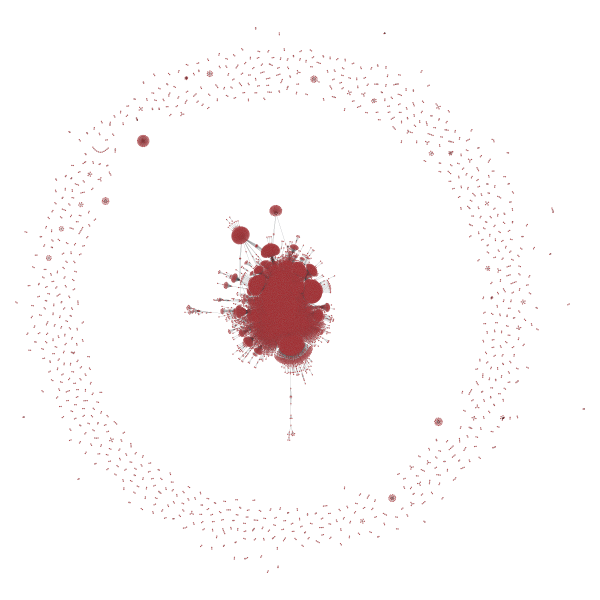

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f46e65ac160, at 0x7f46e667fda0>

In [44]:
graph_draw(G)

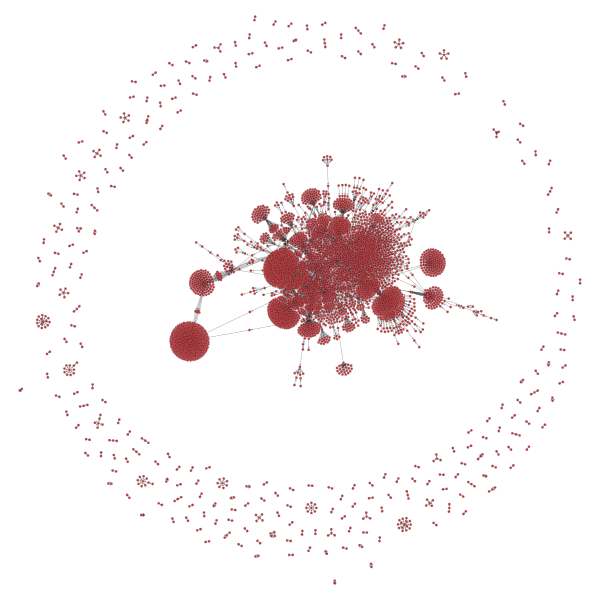

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f46e65ac400, at 0x7f46e6f0a9b0>

In [45]:
graph_drawawraw(S)

In [39]:
v_prop_map[0]

'1966'

In [13]:
start_weights = [float(val) / (10 ** 17) for val in start_weights]

In [11]:
start_weights
final_weights = []
for weight in start_weights:
    if weight < 1:
        final_weights.append(1)
    elif 1 <= weight < 10:
        final_weights.append(2)
    elif 10 <= weight < 100:
        final_weights.append(3)
    else:
        final_weights.append(4)


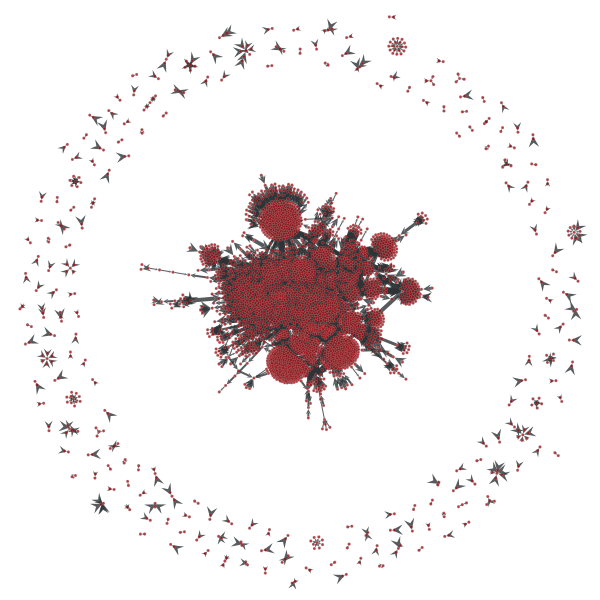

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f46ebb4ecf8, at 0x7f46ec468e80>

In [15]:
graph_draw(G, edge_pen_width=e_weight)

In [24]:
G.get_vertex_filter()

(None, False)

In [25]:
G.get_vertices()

array([   0,    1,    2, ..., 3716, 3717, 3718], dtype=uint64)

In [28]:
G.